In [1]:
# pip install pandas
import pandas as pd
import numpy as np

In [2]:
hist_csv_filename = 'JPM.csv'
summary = {}

In [3]:
def load_past(hist_csv_filename):
    histcolname='Date'
    filedateformat='%Y-%m-%d'
    #yh = pd.read_csv(hist_csv_filename)
    yh = pd.read_csv(
                    hist_csv_filename,
                    #parse_dates=[histcolname],
                    #date_parser=lambda x: datetime.strptime(x,filedateformat),
                    index_col=histcolname)
    yh = yh.rename(columns={'Adj Close': 'AdjClose'})
    return yh

yh=load_past(hist_csv_filename)
yh

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2022-05-31,130.179993,133.149994,129.710007,132.229996,127.951584,17015000
2022-06-01,132.869995,132.869995,128.669998,129.910004,125.706657,10768000
2022-06-02,129.899994,132.009995,128.669998,132.000000,127.729042,8374800
2022-06-03,131.210007,131.770004,129.990005,130.160004,125.948578,8596000
2022-06-06,131.089996,132.389999,129.460007,129.729996,125.532494,11323500
...,...,...,...,...,...,...
2023-05-22,141.000000,141.639999,137.660004,138.029999,138.029999,11402500
2023-05-23,137.539993,139.029999,136.460007,136.589996,136.589996,9514900
2023-05-24,135.399994,136.350006,135.080002,135.339996,135.339996,8578000


In [4]:
summary['hist_filename']=hist_csv_filename
summary['hist_shape']=yh.shape
summary['hist_firstdt']=yh.index[0]
summary['hist_lastdt']=yh.index[-1]


In [5]:
def add_columns(df,AdjClose):
    df['LagAdjClose'] = df[AdjClose].shift(1)
    df['DailyLogRet'] = np.log(df[AdjClose]/df['LagAdjClose'])
    return df

In [6]:
yh=add_columns(yh,'AdjClose')

In [7]:
yh.DailyLogRet.describe()

count    249.000000
mean       0.000273
std        0.017309
min       -0.055657
25%       -0.010019
50%        0.000264
75%        0.009317
max        0.072795
Name: DailyLogRet, dtype: float64

In [8]:
# price[t] = price[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * e)

In [9]:
def getstats(df,DailyLogRet):
    sigma = df[DailyLogRet].std()
    mu = df[DailyLogRet].mean()
    cnt = df[DailyLogRet].count()
    return {'sigma':sigma,'mu':mu,'dretCount':cnt}
    
yhs = getstats(yh,'DailyLogRet')
print(yhs)
summary['hist_stats'] = yhs

{'sigma': 0.017308744241388962, 'mu': 0.0002726544013365923, 'dretCount': 249}


In [10]:
# https://en.wikipedia.org/wiki/Geometric_Brownian_motion#Simulating_sample_paths
# Python code for the plot

import matplotlib.pyplot as plt
#from scipy.stats import norm
import math

In [11]:
np.random.seed(1)

In [12]:
def get_path(drift,vol,n,lastclose):
    dt = 0.1
    x0 = lastclose
    #n = 252
    mu = drift # hstats['mu']
    #sigma_ = vol # hstats['sigma']
    sigma = vol # np.array([sigma_]) # [yh.DailyLogRet.std()].to_numpy()

    #sigma = np.arange(yh.DailyLogRet.std(), yh.DailyLogRet.std()+1, 10)
    # print(sigma) = [0.8 1.  1.2 1.4 1.6 1.8]
    #sigma = np.arange(0.8, 2, 0.2)
    sz=1 # len(sigma)
    x = np.exp(
        (mu - sigma ** 2 / 2) * dt
        +
        sigma * np.random.normal(0, np.sqrt(dt), size=(sz, n)).T
    )

    x = np.vstack([np.ones(sz), x])
    x = x0 * x.cumprod(axis=0)
    #print(x.shape)
    rp = x[:,0]
    #print(rp.shape)
    #print(type(rp).__name__)
    df = pd.DataFrame({'px':rp},index=None) # , index=rows, columns=columns)
    #print(df.columns)
    df=add_columns(df,'px')
    ss=getstats(df,'DailyLogRet')
    #print(df)
    print(ss)
    delete_the_first = True # the first is the last of the provided historical prices
    xfut = rp
    assert len(xfut) == n+1
    
    if delete_the_first:
        xfut = np.delete(rp, 0) # xfut[0] is going to be = xpast[-1], hence this removal.    
    assert len(xfut) == n
    return xfut # rp

In [13]:
from datetime import datetime

In [14]:
rpath = []
fullpath = []

noPaths = 1000

summary['paths'] = noPaths
summary['hist_lastclose'] = yh.AdjClose.iloc[-1]

print('hist profile:',yhs)
lastclose = yh.AdjClose.iloc[-1]
futprices = 252
summary['futprices'] = futprices
summary['exec_start_rand'] = datetime.now()
for ipath in range(noPaths):
    print(ipath)
    rpath.append(get_path(yhs['mu'],yhs['sigma'],futprices,lastclose))
    #print(rpath[ipath])
    #rp=rpath[ipath]
    #df = pd.DataFrame(data=rp,columns=['px'])
    # /math.sqrt(252)

hist profile: {'sigma': 0.017308744241388962, 'mu': 0.0002726544013365923, 'dretCount': 249}
0
{'sigma': 0.005203770514607375, 'mu': 0.00041422423697018006, 'dretCount': 252}
1
{'sigma': 0.00562661687191661, 'mu': 0.00013087409742297708, 'dretCount': 252}
2
{'sigma': 0.005574034607118098, 'mu': 0.00015161364375633596, 'dretCount': 252}
3
{'sigma': 0.005127155663059734, 'mu': 8.597013624150383e-05, 'dretCount': 252}
4
{'sigma': 0.0054709295983523774, 'mu': 0.00029429353448049046, 'dretCount': 252}
5
{'sigma': 0.005670432483368745, 'mu': 0.0007354978008029814, 'dretCount': 252}
6
{'sigma': 0.006018609234999534, 'mu': -0.00039218403612013744, 'dretCount': 252}
7
{'sigma': 0.0052502461870759555, 'mu': 0.00012760630137473856, 'dretCount': 252}
8
{'sigma': 0.005366872889777134, 'mu': 8.021612488694976e-05, 'dretCount': 252}
9
{'sigma': 0.00557214485892431, 'mu': -0.0003341577527589621, 'dretCount': 252}
10
{'sigma': 0.005357475913466998, 'mu': 6.292053079478807e-05, 'dretCount': 252}
11
{'si

{'sigma': 0.005572974613972985, 'mu': -0.0004481682868573785, 'dretCount': 252}
181
{'sigma': 0.005445933757619145, 'mu': -0.0006117847623685497, 'dretCount': 252}
182
{'sigma': 0.005483428968537243, 'mu': -0.00012535081877618917, 'dretCount': 252}
183
{'sigma': 0.005595739970067939, 'mu': -0.00048559724970149087, 'dretCount': 252}
184
{'sigma': 0.005455963111011158, 'mu': 0.00021819061408211352, 'dretCount': 252}
185
{'sigma': 0.00583843498586813, 'mu': 5.6589046436210966e-05, 'dretCount': 252}
186
{'sigma': 0.005827300877659746, 'mu': -5.783856419253711e-05, 'dretCount': 252}
187
{'sigma': 0.005325612227741964, 'mu': 0.0001696171238562584, 'dretCount': 252}
188
{'sigma': 0.006002282522308077, 'mu': -7.941954755806281e-06, 'dretCount': 252}
189
{'sigma': 0.005340790897234289, 'mu': 1.2500666763582742e-05, 'dretCount': 252}
190
{'sigma': 0.005385144333293119, 'mu': 0.0005315045408416862, 'dretCount': 252}
191
{'sigma': 0.005575823754122416, 'mu': -0.00037169467682644515, 'dretCount': 2

{'sigma': 0.005297149102680622, 'mu': -0.00014712723739637937, 'dretCount': 252}
286
{'sigma': 0.005244141160215267, 'mu': 0.00025489280557091856, 'dretCount': 252}
287
{'sigma': 0.005415153631878621, 'mu': 0.00016177227121738717, 'dretCount': 252}
288
{'sigma': 0.005007844245550621, 'mu': 7.038761740452451e-05, 'dretCount': 252}
289
{'sigma': 0.00529083827627399, 'mu': -0.00017989646515950873, 'dretCount': 252}
290
{'sigma': 0.005565131287925409, 'mu': -0.0004081108891420795, 'dretCount': 252}
291
{'sigma': 0.00545762706865102, 'mu': 8.643702120308227e-05, 'dretCount': 252}
292
{'sigma': 0.005603332535488337, 'mu': -0.0002020219972645502, 'dretCount': 252}
293
{'sigma': 0.005503168837493635, 'mu': -0.00031022580740377656, 'dretCount': 252}
294
{'sigma': 0.005450484898502001, 'mu': 5.7536652512577735e-05, 'dretCount': 252}
295
{'sigma': 0.005288613852946072, 'mu': 5.767155594194335e-05, 'dretCount': 252}
296
{'sigma': 0.005596161929273991, 'mu': 0.0002653610505582976, 'dretCount': 252}

{'sigma': 0.0055285226912810724, 'mu': 8.643241589954438e-05, 'dretCount': 252}
391
{'sigma': 0.00520884623322306, 'mu': 0.0002757463711123023, 'dretCount': 252}
392
{'sigma': 0.005490652703489726, 'mu': 9.238675108203778e-05, 'dretCount': 252}
393
{'sigma': 0.005437677321588631, 'mu': 0.00046749863419581533, 'dretCount': 252}
394
{'sigma': 0.0057617218209798215, 'mu': 0.0006353309232079932, 'dretCount': 252}
395
{'sigma': 0.005633228191485662, 'mu': 0.00040485471119943816, 'dretCount': 252}
396
{'sigma': 0.005165691057004173, 'mu': 0.00020577073578150745, 'dretCount': 252}
397
{'sigma': 0.005396487397895381, 'mu': 0.00042236414546711486, 'dretCount': 252}
398
{'sigma': 0.005254204106046514, 'mu': 0.00022031845761512518, 'dretCount': 252}
399
{'sigma': 0.005283094845228542, 'mu': -8.703678719762052e-05, 'dretCount': 252}
400
{'sigma': 0.005580231707280135, 'mu': 0.0001357014087668649, 'dretCount': 252}
401
{'sigma': 0.005642039404470951, 'mu': -0.0004906579842074184, 'dretCount': 252}


{'sigma': 0.0053539525285862715, 'mu': 0.000209813738594281, 'dretCount': 252}
495
{'sigma': 0.005811534153907407, 'mu': 0.0005258547743980053, 'dretCount': 252}
496
{'sigma': 0.005387496961550795, 'mu': -5.605737552156563e-05, 'dretCount': 252}
497
{'sigma': 0.005477972941305813, 'mu': 0.0002865144934242108, 'dretCount': 252}
498
{'sigma': 0.005503591554011092, 'mu': 0.00022292894326148775, 'dretCount': 252}
499
{'sigma': 0.005358279240214176, 'mu': -5.5969018082939896e-05, 'dretCount': 252}
500
{'sigma': 0.005108910540443069, 'mu': 0.00020185997929531287, 'dretCount': 252}
501
{'sigma': 0.00551743697851465, 'mu': -0.0002502430399661796, 'dretCount': 252}
502
{'sigma': 0.0054938209163367295, 'mu': -0.00047278693072759975, 'dretCount': 252}
503
{'sigma': 0.005370650829470234, 'mu': 0.0003742823486059994, 'dretCount': 252}
504
{'sigma': 0.005348453586436654, 'mu': 0.00016291933046153775, 'dretCount': 252}
505
{'sigma': 0.0053197530979561276, 'mu': -6.502354106678051e-05, 'dretCount': 25

{'sigma': 0.005668838988733304, 'mu': -7.359230651297255e-05, 'dretCount': 252}
595
{'sigma': 0.005519557725289068, 'mu': -0.00022433757925602093, 'dretCount': 252}
596
{'sigma': 0.005712420483676107, 'mu': 0.00017327181284303319, 'dretCount': 252}
597
{'sigma': 0.0053425716967612285, 'mu': 9.736511597506468e-05, 'dretCount': 252}
598
{'sigma': 0.005113934243025716, 'mu': -3.84206729089345e-05, 'dretCount': 252}
599
{'sigma': 0.005913855520075645, 'mu': 7.562574813806155e-07, 'dretCount': 252}
600
{'sigma': 0.0057774904370251874, 'mu': -0.000148652319579352, 'dretCount': 252}
601
{'sigma': 0.00515528577087818, 'mu': -0.00029330245918487334, 'dretCount': 252}
602
{'sigma': 0.005534047021000506, 'mu': 4.270121492753981e-05, 'dretCount': 252}
603
{'sigma': 0.005471690474092218, 'mu': -0.0003691116738303293, 'dretCount': 252}
604
{'sigma': 0.005520597462403433, 'mu': 0.000357418573572726, 'dretCount': 252}
605
{'sigma': 0.005610180598519126, 'mu': -0.0002684914534538997, 'dretCount': 252}


{'sigma': 0.005486752631803197, 'mu': -6.414710456673921e-05, 'dretCount': 252}
698
{'sigma': 0.005113310843268258, 'mu': 0.0006987333240262612, 'dretCount': 252}
699
{'sigma': 0.0053571666788943765, 'mu': 4.972869131494773e-05, 'dretCount': 252}
700
{'sigma': 0.005348782944837126, 'mu': 0.0006273014530785206, 'dretCount': 252}
701
{'sigma': 0.005383063545463137, 'mu': 0.00018080777786008912, 'dretCount': 252}
702
{'sigma': 0.005412421556940966, 'mu': -0.0001731739514782224, 'dretCount': 252}
703
{'sigma': 0.005475559924999135, 'mu': -0.0007437554246739407, 'dretCount': 252}
704
{'sigma': 0.005660315854002703, 'mu': 0.0004871987262307114, 'dretCount': 252}
705
{'sigma': 0.0056282834990963315, 'mu': -5.0798974189102174e-05, 'dretCount': 252}
706
{'sigma': 0.005590238540784532, 'mu': -0.0004680395989426054, 'dretCount': 252}
707
{'sigma': 0.005644895082272699, 'mu': 0.00046011770371163764, 'dretCount': 252}
708
{'sigma': 0.00542714262157662, 'mu': 9.09044899197261e-05, 'dretCount': 252}


{'sigma': 0.005805877157386652, 'mu': 0.0007724330407023031, 'dretCount': 252}
803
{'sigma': 0.005616834964797912, 'mu': -0.0003323392074339592, 'dretCount': 252}
804
{'sigma': 0.00510615521807853, 'mu': -0.0004974071509149391, 'dretCount': 252}
805
{'sigma': 0.005294590116845369, 'mu': -0.00041331651762495017, 'dretCount': 252}
806
{'sigma': 0.00566447313938335, 'mu': -0.00018239936956206766, 'dretCount': 252}
807
{'sigma': 0.005411183715632641, 'mu': -0.0001308155867867539, 'dretCount': 252}
808
{'sigma': 0.0051875966597553945, 'mu': 0.0001580366405061603, 'dretCount': 252}
809
{'sigma': 0.005798083175694996, 'mu': 0.00015361363125663622, 'dretCount': 252}
810
{'sigma': 0.005380194877442456, 'mu': 8.94098710087533e-05, 'dretCount': 252}
811
{'sigma': 0.0053141364935049935, 'mu': -0.0002924070406588499, 'dretCount': 252}
812
{'sigma': 0.005522222576247076, 'mu': -4.6999284426338197e-05, 'dretCount': 252}
813
{'sigma': 0.006033644623245218, 'mu': 0.0001674009512957707, 'dretCount': 252

{'sigma': 0.005694418215997942, 'mu': 0.00026473238897636257, 'dretCount': 252}
911
{'sigma': 0.005313354604984002, 'mu': -0.00026619221394192115, 'dretCount': 252}
912
{'sigma': 0.005655741830600526, 'mu': 6.52381239960787e-05, 'dretCount': 252}
913
{'sigma': 0.006091573726923192, 'mu': 2.0504330278896608e-05, 'dretCount': 252}
914
{'sigma': 0.00555977634866073, 'mu': -0.000442716948394564, 'dretCount': 252}
915
{'sigma': 0.0055549433800999495, 'mu': -0.00038313096064358543, 'dretCount': 252}
916
{'sigma': 0.005761833994919879, 'mu': -5.6391994476045955e-05, 'dretCount': 252}
917
{'sigma': 0.005493676285176299, 'mu': 0.000333723535549735, 'dretCount': 252}
918
{'sigma': 0.0057152724122846174, 'mu': 0.00023823303949256644, 'dretCount': 252}
919
{'sigma': 0.005813075711324343, 'mu': -0.0004904554784323897, 'dretCount': 252}
920
{'sigma': 0.005269169166125409, 'mu': -0.0004648259730815981, 'dretCount': 252}
921
{'sigma': 0.0059002528220311375, 'mu': -0.0005373249957462046, 'dretCount': 2

In [15]:
#import math
#math.sqrt(250)

In [16]:
xpast = yh.AdjClose.values # = yh.AdjClose.to_numpy()
for ipath in range(noPaths):
    print(ipath)
    #print(type(xpast).__name__)
    #print(xpast.shape)
    xfut = rpath[ipath]
    #xfut = xfut_z 
    print('len xfut',len(xfut))
#    xfut = np.delete(xfut_z, 0) # xfut[0] is going to be = xpast[-1], hence this removal.
    #print(type(xfut).__name__)
    #print(xfut.shape)
    full = np.concatenate([xpast,xfut])
    print('len full',len(full))
    fullpath.append(full)
    #print(len(full))
    #plt.plot(full)
    #print(type(x).__name__)
    print('last 2 xpast',xpast[-2],xpast[-1],'first 2 xfut',xfut[0],xfut[1])


0
len xfut 252
len full 502
last 2 xpast 135.669998 136.940002 first 2 xfut 138.1646427498783 137.70447055708019
1
len xfut 252
len full 502
last 2 xpast 135.669998 136.940002 first 2 xfut 134.86404648414455 136.303575154975
2
len xfut 252
len full 502
last 2 xpast 135.669998 136.940002 first 2 xfut 136.74770107758033 136.8911402425651
3
len xfut 252
len full 502
last 2 xpast 135.669998 136.940002 first 2 xfut 136.2307810483625 135.70825360718334
4
len xfut 252
len full 502
last 2 xpast 135.669998 136.940002 first 2 xfut 137.36330859462075 138.5086230149739
5
len xfut 252
len full 502
last 2 xpast 135.669998 136.940002 first 2 xfut 136.93950666297766 136.89575128249126
6
len xfut 252
len full 502
last 2 xpast 135.669998 136.940002 first 2 xfut 137.08308772242947 137.11991558557838
7
len xfut 252
len full 502
last 2 xpast 135.669998 136.940002 first 2 xfut 136.32269620633915 137.04551053386226
8
len xfut 252
len full 502
last 2 xpast 135.669998 136.940002 first 2 xfut 138.05281567939937

In [17]:
if False:
    for ipath in range(noPaths):
        plt.plot(fullpath[ipath])
        plt.title("Realizations of Geometric Brownian Motion")
    #plt.show()

In [18]:
# now merge with M:\DEV\A-MOSCATELLI-WIKI\next_timeseries-accumulator

# part 2 - simulation

In [19]:
import yaml  # pip install pyyaml
from datetime import datetime, timedelta

In [20]:
def load_contract_spec(contract):
    with open(contract, 'r') as file:
        contract_spec = yaml.safe_load(file)
        if False:
            contract_spec['dates']['startdate'] = datetime.strptime(contract_spec['dates']['startdate'],   contract_spec['dates']['dateformat'])
            contract_spec['dates']['enddate']   = datetime.strptime(contract_spec['dates']['enddate'],     contract_spec['dates']['dateformat'])
        # 2022-07-08
            del contract_spec['dates']['dateformat']
        #print(contract_spec)
        return contract_spec


In [21]:
class Hdf:
    df = None
    def _dbg(self,trace):
        print('count of dates after','<'+trace+'>',':',self.df.shape[0])
    #def __init__(self):
        #self._dbg('init')
    
    def load_df(self,df):
        self.df = df
        
    def load_csv(self, hist_csv_filename,histcolname,filedateformat):
        self.df = pd.read_csv(
                    hist_csv_filename,
                    parse_dates=[histcolname],
                    date_parser=lambda x: datetime.strptime(x,filedateformat),
                    index_col=histcolname)
        self._dbg('init')
        # https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/ follows the same steps
        False and print(self.df.dtypes)

    def withSignal(self,colname,lambdasignal,activation):
        assert False
        assert activation in ['up','down']
        self.df[colname] = self.df.apply(lambda row: lambdasignal(row), axis=1).copy()
        fdf = self.df[self.df[colname]]
        if fdf.shape[0]>=0:
            activation_index = fdf.index[0]
            print('activation_index',activation_index)
            if activation=='up':
                self.df[colname] = self.df.apply(lambda row: row.name >= activation_index, axis=1).copy()
            if activation=='down':
                self.df[colname] = self.df.apply(lambda row: row.name <= activation_index, axis=1).copy()
        self._dbg(colname)
        return self

In [22]:
def hist(field,date,dayoffset):
    assert dayoffset <= 0
    # date is str
    #date_ = datetime.strptime(date,"%Y-%m-%d")
    #date2 = date + timedelta(days=dayoffset)	# may not be included in the df
    #print('hist:',date,field,dayoffset,date2)
    ret = hdf.df.shift(dayoffset).at[date,field]
    #print('shifted hist:',hdf.df.shift(dayoffset).loc[date])
    #ret = hdf.df.at[date2,field]
    #print('ret:',ret)
    if not ret: ret=0
    return ret


## start

In [23]:
folder = r'M:\DEV\github__a_moscatelli\repositories\home\am-wiki-assets\equityaccumulator'+'\\'

In [58]:
contract = folder + 'contract.yml'
summary['contract_specs']='contract.yml'
in_csv_filename = folder + 'jpm.csv'
contract_spec = load_contract_spec(contract)
summary['exec_start_simul'] = datetime.now()

In [25]:
#lastdate=yh.index[-1]
#lastdt=datetime.strptime(lastdate,"%Y-%m-%d")


def getnextdt(lastdt,considerPublicHolidays, useStrings):
    assert not considerPublicHolidays
    if useStrings:
        lastdt=datetime.strptime(lastdt,"%Y-%m-%d")
    dow_eur=lastdt.strftime("%a")
    #print(lastdt,dow_eur)
    offset=1
    if dow_eur=='Fri': offset=3
    if dow_eur=='Sat': offset=2
    
    lastdt = lastdt + timedelta(days=offset)
    if useStrings:
        return datetime.strftime(lastdt,"%Y-%m-%d")
    else:
        return lastdt




In [26]:
def get_future_dates(lastdate,path):
    futdt = []
    curdt=lastdate
    futpathx=rpath[path]
    for px in futpathx:
        curdt=getnextdt(curdt,False,True)
        futdt.append(curdt)
        #print(px)
        #pass
    assert len(futdt) == len(rpath[path])
    return futdt

In [27]:
def compute1_noncumul(hdf,contract_spec):
    
    #print(contract_spec['dates']['startdate'], contract_spec['dates']['enddate'])
    hdf.df['live'] = hdf.df.apply(lambda row:  contract_spec['dates']['startdate'] <= row.name <= contract_spec['dates']['enddate'], axis=1)
    hdf.df['KI'] = hdf.df.apply(lambda row:  row.live and eval(contract_spec['knock-in'],{'row':row}), axis=1).cummax()
    # the input of cummax is a df column having true when the KI condition is met. cummax() keeps confirming True in the future once met. cummax = carryover of True.
    hdf.df['KO'] = hdf.df.apply(lambda row:  row.KI and eval(contract_spec['knock-out'],{'row':row}), axis=1).cummax()
    hdf.df['accumulation'] = hdf.df['KI'] & ~hdf.df['KO']
    # bitwise is inside the KI zone and not inside the KO zone
    return hdf




In [28]:
import math

In [29]:
def compute2_cumul(hdf,contract_spec):

    hdf.df.insert(0, 'SN', range(0, 0 + len(hdf.df)))

    hdf.df['BQty']  = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['buy']['qty'],  {'row':row, 'math':math,'hist':hist,'T':row.name}), axis=1)
    hdf.df['BAt']   = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['buy']['at'],   {'row':row, 'math':math,'hist':hist,'T':row.name}), axis=1)
    hdf.df['BWhen'] = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['buy']['when'], {'row':row, 'math':math,'hist':hist,'T':row.name}), axis=1)
    hdf.df['SQty']  = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['sell']['qty'], {'row':row, 'math':math,'hist':hist,'T':row.name}), axis=1)
    hdf.df['SAt']   = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['sell']['at'],  {'row':row, 'math':math,'hist':hist,'T':row.name}), axis=1)
    hdf.df['SWhen'] = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['sell']['when'],{'row':row, 'math':math,'hist':hist,'T':row.name}), axis=1)
    #cashflow
    hdf.df['BCF']   = hdf.df.apply(lambda row: row.accumulation and row.BWhen and - (row.BQty * row.BAt),axis=1)
    hdf.df['SCF']   = hdf.df.apply(lambda row: row.accumulation and row.SWhen and + (row.SQty * row.SAt),axis=1)
    #cumul
    hdf.df['CumQty']= hdf.df.apply(lambda row: row.BWhen and row.BQty - row.SWhen and row.SQty , axis=1).cumsum()
    hdf.df['CumCF'] = hdf.df.apply(lambda row: row.BCF + row.SCF, axis=1).cumsum()
    return hdf



In [30]:
assert max(True,False)==True and min(True,False)==False
lastCumCF_array = []
lastdate=yh.index[-1]

futdt = get_future_dates(lastdate,0)
summary['fut_firstdt'] = futdt[0]
summary['fut_lastdt'] = futdt[-1]

In [31]:
[ print(kk,'=>',summary[kk]) for kk in summary.keys()] 

hist_filename => JPM.csv
hist_shape => (250, 6)
hist_firstdt => 2022-05-31
hist_lastdt => 2023-05-26
hist_stats => {'sigma': 0.017308744241388962, 'mu': 0.0002726544013365923, 'dretCount': 249}
paths => 1000
hist_lastclose => 136.940002
futprices => 252
exec_start_rand => 2023-09-04 21:05:17.859858
exec_start_simul => 2023-09-04 21:05:20.313508
fut_firstdt => 2023-05-29
fut_lastdt => 2024-05-14


[None, None, None, None, None, None, None, None, None, None, None, None]

In [32]:
import statistics

In [33]:

for ipath in range(noPaths):
    #plt.plot(fullpath[ipath])
    #plt.title("Realizations of Geometric Brownian Motion")
    #plt.show()
    
    rpathx=rpath[ipath]
    print('min/max/avg path px',min(rpathx),max(rpathx),statistics.mean(rpathx))
    futdf = pd.DataFrame({'AdjClose':rpathx},index=futdt)
    fulldf = pd.concat([yh,futdf])
    
    # simulate accumulation
    #del hdf0
    hdf0 = Hdf()
    hdf0.load_df(fulldf)
    hdf = compute1_noncumul(hdf0,contract_spec)
    if hdf.df.loc[hdf.df.accumulation].shape[0]>0:
        print('accumulation start:',hdf.df.loc[hdf.df.accumulation].head(1).index.values[0]) # .loc[hdf.df['accumulation']==True].idxmin())
        print('accumulation stop:',hdf.df.loc[hdf.df.accumulation].tail(1).index.values[0]) # .loc[hdf.df.accumulation==True].idxmax())
    else:
        print('accumulation starts/stops: NEVER')
        
    hdf = compute2_cumul(hdf,contract_spec)
    # hdf.df
    lastCumCF=hdf.df["CumCF"].iloc[-1]
    avgCumCF=hdf.df["CumCF"].mean()
    print('ipath',ipath,'CumCF',lastCumCF,'avgCumCF',avgCumCF)
    lastCumCF_array.append(lastCumCF)
    
    if False:
        plt.plot(hdf.df["CumCF"]) #, df["Y"])
        plt.show()
        

min/max/avg path px 132.41636890295996 157.34055651533592 143.55509457997323
accumulation start: 2023-12-22
accumulation stop: 2024-05-14
ipath 0 CumCF -7943.808219036076 avgCumCF -465.896925987675
min/max/avg path px 134.86404648414455 148.1240221202873 140.74744773497588
accumulation start: 2023-09-14
accumulation stop: 2024-05-14
ipath 1 CumCF -21228.433485081583 avgCumCF -3941.840695316729
min/max/avg path px 136.09285822988073 149.08771847697565 143.36551720585473
accumulation start: 2023-09-06
accumulation stop: 2024-05-14
ipath 2 CumCF -17358.809968016616 avgCumCF -3680.484732675516
min/max/avg path px 131.0500058045387 150.90501887727532 140.79335865560245
accumulation start: 2023-11-17
accumulation stop: 2024-05-14
ipath 3 CumCF -13248.629076810561 avgCumCF -1054.6802734521175
min/max/avg path px 134.32344615040023 147.48181189451418 139.86700872348874
accumulation start: 2023-10-05
accumulation stop: 2024-05-14
ipath 4 CumCF -18857.890034905286 avgCumCF -4433.337569981311
min

ipath 47 CumCF -9185.511637647287 avgCumCF -678.1793192215366
min/max/avg path px 135.8089889097856 153.7710821487907 146.04831710013158
accumulation start: 2023-08-25
accumulation stop: 2024-05-14
ipath 48 CumCF -16724.265470244267 avgCumCF -2215.84859407784
min/max/avg path px 134.6781998850899 162.02408684907329 147.70474375905647
accumulation start: 2023-10-02
accumulation stop: 2024-05-14
ipath 49 CumCF 10578.020560373732 avgCumCF 606.2718083016483
min/max/avg path px 120.98967450883366 144.3532739297383 136.12455169479082
accumulation starts/stops: NEVER
ipath 50 CumCF 0 avgCumCF 0.0
min/max/avg path px 106.78583837289877 137.8548476762258 123.50124846222744
accumulation starts/stops: NEVER
ipath 51 CumCF 0 avgCumCF 0.0
min/max/avg path px 121.11704331569307 137.9282909978531 129.1594108396085
accumulation starts/stops: NEVER
ipath 52 CumCF 0 avgCumCF 0.0
min/max/avg path px 135.6146011673044 158.510739303533 145.6543572002872
accumulation start: 2023-10-27
accumulation stop: 202

ipath 96 CumCF -25014.08863783671 avgCumCF -3270.0446357600185
min/max/avg path px 122.17001001301473 140.37253795386405 131.61537214922652
accumulation starts/stops: NEVER
ipath 97 CumCF 0 avgCumCF 0.0
min/max/avg path px 129.87867667513098 142.5277436955188 135.43391643843148
accumulation starts/stops: NEVER
ipath 98 CumCF 0 avgCumCF 0.0
min/max/avg path px 129.6547218747821 145.45939637515522 134.7033907765936
accumulation start: 2024-05-06
accumulation stop: 2024-05-14
ipath 99 CumCF -448.28354289676247 avgCumCF -5.60892127169235
min/max/avg path px 121.08262432122447 136.9346456601559 128.80659549179788
accumulation starts/stops: NEVER
ipath 100 CumCF 0 avgCumCF 0.0
min/max/avg path px 130.1341332861187 149.25012840053236 138.5696241597251
accumulation start: 2024-03-26
accumulation stop: 2024-05-14
ipath 101 CumCF -186.05959577621525 avgCumCF -52.76342111673399
min/max/avg path px 127.1421384722757 139.74999371843796 133.34394081683996
accumulation starts/stops: NEVER
ipath 102 C

ipath 145 CumCF 13347.216912025036 avgCumCF 3206.4000519675824
min/max/avg path px 119.331134429854 137.4223453666844 128.1543932192607
accumulation starts/stops: NEVER
ipath 146 CumCF 0 avgCumCF 0.0
min/max/avg path px 136.0717474633391 156.42881865281277 145.95290103581445
accumulation start: 2023-10-11
accumulation stop: 2024-05-14
ipath 147 CumCF 11286.54352273691 avgCumCF 1180.0124828406151
min/max/avg path px 136.01901402618452 150.7155977307515 140.95797972220257
accumulation start: 2024-01-10
accumulation stop: 2024-05-14
ipath 148 CumCF -7160.681432633957 avgCumCF 55.823240370116075
min/max/avg path px 133.30943191850636 146.39283913362715 139.92261731523038
accumulation start: 2024-02-09
accumulation stop: 2024-05-14
ipath 149 CumCF -17860.811216745187 avgCumCF -1382.8000574174716
min/max/avg path px 122.8511570449169 143.95196694889677 133.04109504424676
accumulation starts/stops: NEVER
ipath 150 CumCF 0 avgCumCF 0.0
min/max/avg path px 117.68128465485898 136.44074416619966 

ipath 195 CumCF -624.5427974945891 avgCumCF -261.68998785988094
min/max/avg path px 135.66843889676042 145.98864911101643 139.8187168818822
accumulation start: 2024-01-11
accumulation stop: 2024-05-14
ipath 196 CumCF -9449.305396705642 avgCumCF -1258.3304221878986
min/max/avg path px 133.52136562051285 145.2085877212116 139.0091682218882
accumulation start: 2023-08-29
accumulation stop: 2024-05-14
ipath 197 CumCF -7855.879774790083 avgCumCF -2300.603568091922
min/max/avg path px 134.57651210023067 160.45723673395838 144.06574092361043
accumulation start: 2023-12-11
accumulation stop: 2024-05-14
ipath 198 CumCF -2354.290475343769 avgCumCF -756.2213999300152
min/max/avg path px 125.06892205195736 136.6824646207726 129.96217543574772
accumulation starts/stops: NEVER
ipath 199 CumCF 0 avgCumCF 0.0
min/max/avg path px 120.0207179471221 142.65147401657833 132.15465739782312
accumulation starts/stops: NEVER
ipath 200 CumCF 0 avgCumCF 0.0
min/max/avg path px 130.54070584349336 150.211172844058

ipath 242 CumCF 0 avgCumCF 0.0
min/max/avg path px 135.11495762260805 157.55985269636838 145.7654475194622
accumulation start: 2023-08-14
accumulation stop: 2024-05-14
ipath 243 CumCF -14569.456088580202 avgCumCF -4142.738252659748
min/max/avg path px 129.04619268375885 142.0032406811809 135.49494827702287
accumulation starts/stops: NEVER
ipath 244 CumCF 0 avgCumCF 0.0
min/max/avg path px 135.92407536734564 156.154220942799 146.55320319160586
accumulation start: 2023-07-19
accumulation stop: 2024-05-14
ipath 245 CumCF -21110.858957067045 avgCumCF -3686.483217737663
min/max/avg path px 130.20765861302502 145.57591797297925 136.99149673028802
accumulation start: 2023-11-08
accumulation stop: 2024-05-14
ipath 246 CumCF -14274.723693726619 avgCumCF -2737.206756692525
min/max/avg path px 121.30999666998765 136.08161155091545 129.8495431646178
accumulation starts/stops: NEVER
ipath 247 CumCF 0 avgCumCF 0.0
min/max/avg path px 133.81908063673652 152.26020781409312 140.13765746017063
accumulat

ipath 291 CumCF 0 avgCumCF 0.0
min/max/avg path px 129.324477685959 140.00254079091437 134.6100679209383
accumulation starts/stops: NEVER
ipath 292 CumCF 0 avgCumCF 0.0
min/max/avg path px 121.51585568960299 136.90168426510573 126.78258569208963
accumulation starts/stops: NEVER
ipath 293 CumCF 0 avgCumCF 0.0
min/max/avg path px 128.63398256241518 139.401335677869 133.9839670065076
accumulation starts/stops: NEVER
ipath 294 CumCF 0 avgCumCF 0.0
min/max/avg path px 135.50149945777005 152.2027200245501 142.83221887019752
accumulation start: 2023-08-30
accumulation stop: 2024-05-14
ipath 295 CumCF -11820.327600503722 avgCumCF -1753.800825841569
min/max/avg path px 130.6334538418937 146.82755629647542 138.4274326815793
accumulation start: 2024-04-29
accumulation stop: 2024-05-14
ipath 296 CumCF -1633.6843003048516 avgCumCF -45.09140790965345
min/max/avg path px 119.55407753177906 137.3914907499199 128.1193034992116
accumulation starts/stops: NEVER
ipath 297 CumCF 0 avgCumCF 0.0
min/max/avg 

ipath 340 CumCF 9853.833556567639 avgCumCF 1076.7178146624808
min/max/avg path px 133.7772007935857 163.94216760360976 149.14504871481665
accumulation start: 2023-10-06
accumulation stop: 2024-05-14
ipath 341 CumCF -11624.869688494564 avgCumCF -1558.9118662737792
min/max/avg path px 136.6424982362452 164.01327352661644 149.8596947440816
accumulation start: 2023-07-05
accumulation stop: 2024-05-14
ipath 342 CumCF 11786.91117401579 avgCumCF 263.65672310183265
min/max/avg path px 132.1214252311771 144.5176614984561 138.1523782590983
accumulation starts/stops: NEVER
ipath 343 CumCF 0 avgCumCF 0.0
min/max/avg path px 130.53530180489165 147.28907590302845 139.37040046842648
accumulation start: 2024-01-26
accumulation stop: 2024-05-14
ipath 344 CumCF -4853.916081818775 avgCumCF -775.8244360098543
min/max/avg path px 136.3745969704098 150.9795594012038 144.27229996808293
accumulation start: 2023-08-17
accumulation stop: 2024-05-14
ipath 345 CumCF -31159.222990215865 avgCumCF -6215.030410191873

ipath 389 CumCF 5794.071098846708 avgCumCF 162.3421385834236
min/max/avg path px 134.63260434815743 145.7572820020777 139.67097521345335
accumulation start: 2023-08-02
accumulation stop: 2024-05-14
ipath 390 CumCF -20721.60945452051 avgCumCF -4427.427859841625
min/max/avg path px 136.0836453260221 152.54097677024515 143.83922023740973
accumulation start: 2023-12-19
accumulation stop: 2024-05-14
ipath 391 CumCF -528.2234074717878 avgCumCF 866.8938054527425
min/max/avg path px 131.3740764006763 144.08824935778028 138.53991498876948
accumulation starts/stops: NEVER
ipath 392 CumCF 0 avgCumCF 0.0
min/max/avg path px 128.6027168917083 154.24479398316026 139.31628249061015
accumulation start: 2024-01-04
accumulation stop: 2024-05-14
ipath 393 CumCF -7668.590830268107 avgCumCF -1197.151323295665
min/max/avg path px 134.2123430132876 161.9986191855823 148.21922613380596
accumulation start: 2023-08-11
accumulation stop: 2024-05-14
ipath 394 CumCF -22410.43758566128 avgCumCF -4996.316418224103
m

ipath 438 CumCF -12612.720352165235 avgCumCF -1438.2465739866261
min/max/avg path px 134.4716956838351 154.08678933679735 145.92908892948066
accumulation start: 2023-08-15
accumulation stop: 2024-05-14
ipath 439 CumCF -7322.790367905462 avgCumCF 1058.6204592211077
min/max/avg path px 105.1705538023713 138.0246078393399 118.70322857242081
accumulation starts/stops: NEVER
ipath 440 CumCF 0 avgCumCF 0.0
min/max/avg path px 136.92700750426573 150.62787347095838 143.50527065492145
accumulation start: 2023-10-04
accumulation stop: 2024-05-14
ipath 441 CumCF -7723.873447425512 avgCumCF -1689.6589134947585
min/max/avg path px 129.35440425952575 140.1436083980523 134.2086711551478
accumulation starts/stops: NEVER
ipath 442 CumCF 0 avgCumCF 0.0
min/max/avg path px 127.0944975664286 139.20847082359964 134.482690207134
accumulation starts/stops: NEVER
ipath 443 CumCF 0 avgCumCF 0.0
min/max/avg path px 129.60559617043947 139.2463911929016 134.6851057930493
accumulation starts/stops: NEVER
ipath 444

ipath 486 CumCF -3106.6999440810177 avgCumCF -580.0056868382477
min/max/avg path px 128.69294843999333 144.87696352675633 137.67729970197738
accumulation starts/stops: NEVER
ipath 487 CumCF 0 avgCumCF 0.0
min/max/avg path px 133.09424479905917 170.96988180002148 155.61900618452674
accumulation start: 2023-07-24
accumulation stop: 2024-05-14
ipath 488 CumCF 13358.18989065235 avgCumCF 3484.3739085672664
min/max/avg path px 137.07640865254015 160.16311977172737 153.1533226502213
accumulation start: 2023-06-14
accumulation stop: 2024-05-14
ipath 489 CumCF -7755.959105647988 avgCumCF -233.51415999462222
min/max/avg path px 129.80607261141154 140.0810699476831 134.89656183809086
accumulation starts/stops: NEVER
ipath 490 CumCF 0 avgCumCF 0.0
min/max/avg path px 127.40019477799335 140.06039208882166 133.7794449505937
accumulation starts/stops: NEVER
ipath 491 CumCF 0 avgCumCF 0.0
min/max/avg path px 131.24821915638466 145.1559566068961 137.04911974998853
accumulation start: 2024-04-29
accumul

accumulation starts/stops: NEVER
ipath 533 CumCF 0 avgCumCF 0.0
min/max/avg path px 132.35383647498986 143.30339841146744 138.07293967826337
accumulation starts/stops: NEVER
ipath 534 CumCF 0 avgCumCF 0.0
min/max/avg path px 136.23270818317775 170.4135311385463 157.02859867014266
accumulation start: 2023-07-06
accumulation stop: 2024-05-14
ipath 535 CumCF -7414.510920446848 avgCumCF 1652.0274841776138
min/max/avg path px 134.37250783605884 162.335354607996 151.0138882174594
accumulation start: 2023-08-03
accumulation stop: 2024-05-14
ipath 536 CumCF -2955.3285713998175 avgCumCF -655.0595658901436
min/max/avg path px 134.92172799305428 161.76644115391358 144.79298788965338
accumulation start: 2023-09-21
accumulation stop: 2024-05-14
ipath 537 CumCF 479.8076137923093 avgCumCF -544.067619681853
min/max/avg path px 132.20076346891375 147.46075172913967 140.82789881673045
accumulation start: 2023-07-19
accumulation stop: 2024-05-14
ipath 538 CumCF -19933.954531588133 avgCumCF -4358.45010474

ipath 581 CumCF -14437.992973726861 avgCumCF -2451.4074928539962
min/max/avg path px 125.36587204606496 139.59366711235785 133.32521194344594
accumulation starts/stops: NEVER
ipath 582 CumCF 0 avgCumCF 0.0
min/max/avg path px 111.06689094155207 138.03497722912243 120.38012711095378
accumulation starts/stops: NEVER
ipath 583 CumCF 0 avgCumCF 0.0
min/max/avg path px 118.63677886236503 138.58417849621077 125.65124821894929
accumulation starts/stops: NEVER
ipath 584 CumCF 0 avgCumCF 0.0
min/max/avg path px 130.06206488655997 170.8294703198654 145.2629111804682
accumulation start: 2023-12-26
accumulation stop: 2024-05-14
ipath 585 CumCF 10531.104216479029 avgCumCF 2256.798974141439
min/max/avg path px 123.76476585823185 137.87571053213256 130.59347821569094
accumulation starts/stops: NEVER
ipath 586 CumCF 0 avgCumCF 0.0
min/max/avg path px 122.4951290055024 136.72317420860546 130.36858866279272
accumulation starts/stops: NEVER
ipath 587 CumCF 0 avgCumCF 0.0
min/max/avg path px 124.554217329

ipath 631 CumCF -20665.198562234782 avgCumCF -3019.5486367346975
min/max/avg path px 132.4649821192963 144.84623744405664 139.07406461843465
accumulation starts/stops: NEVER
ipath 632 CumCF 0 avgCumCF 0.0
min/max/avg path px 114.56139770552353 139.2781386880407 125.47273930005859
accumulation starts/stops: NEVER
ipath 633 CumCF 0 avgCumCF 0.0
min/max/avg path px 130.48232603644024 145.47880625866122 138.1026442274241
accumulation start: 2023-10-30
accumulation stop: 2024-05-14
ipath 634 CumCF -21470.616073779536 avgCumCF -4246.698777061847
min/max/avg path px 132.21599956180842 148.42450493940743 140.57369763416787
accumulation start: 2023-11-30
accumulation stop: 2024-05-14
ipath 635 CumCF -14883.90432596455 avgCumCF -1374.235494635997
min/max/avg path px 135.1980787486895 158.71362791550254 146.80448607991704
accumulation start: 2023-08-25
accumulation stop: 2024-05-14
ipath 636 CumCF 4540.14372122361 avgCumCF 1148.667136270479
min/max/avg path px 111.31643613314043 136.9858192335572

ipath 679 CumCF -13665.408804514733 avgCumCF -4754.595765255942
min/max/avg path px 127.4858678766782 148.3109038649311 140.693050853568
accumulation start: 2023-11-09
accumulation stop: 2024-05-14
ipath 680 CumCF -8995.395878709773 avgCumCF 48.70225216008778
min/max/avg path px 133.314148760313 147.52821564674778 139.85558105225826
accumulation start: 2023-11-27
accumulation stop: 2024-05-14
ipath 681 CumCF -15755.723038780701 avgCumCF -1640.808731770898
min/max/avg path px 125.55150084771763 138.89892694294045 132.35554109008314
accumulation starts/stops: NEVER
ipath 682 CumCF 0 avgCumCF 0.0
min/max/avg path px 135.84570472813897 161.29073164666352 147.98262421820306
accumulation start: 2023-08-10
accumulation stop: 2024-05-14
ipath 683 CumCF -25155.051317549245 avgCumCF -5471.042661597167
min/max/avg path px 125.06822371920813 141.0822551224779 134.19707362289762
accumulation starts/stops: NEVER
ipath 684 CumCF 0 avgCumCF 0.0
min/max/avg path px 136.68256454846374 160.34488683668036

ipath 725 CumCF -11268.453938216455 avgCumCF 422.990502023965
min/max/avg path px 133.6649900944731 147.68911467470156 141.39100304381603
accumulation start: 2023-10-11
accumulation stop: 2024-05-14
ipath 726 CumCF -18986.721812988733 avgCumCF -2042.3594872633298
min/max/avg path px 135.82037025726 154.36247862564517 146.93994596850308
accumulation start: 2023-07-10
accumulation stop: 2024-05-14
ipath 727 CumCF -22485.872604761193 avgCumCF -3246.6576893617125
min/max/avg path px 133.77599409775934 157.46375074223704 142.77102629125417
accumulation start: 2024-01-11
accumulation stop: 2024-05-14
ipath 728 CumCF -5366.371984870809 avgCumCF 65.21670650167601
min/max/avg path px 134.30599901992542 152.44921881502742 146.59663075575799
accumulation start: 2023-07-17
accumulation stop: 2024-05-14
ipath 729 CumCF -6616.668405660432 avgCumCF -777.923029061775
min/max/avg path px 123.42967953660539 139.93470996483487 131.8940433496087
accumulation starts/stops: NEVER
ipath 730 CumCF 0 avgCumCF 

ipath 774 CumCF -4767.22907960142 avgCumCF -2354.2401767733663
min/max/avg path px 114.37697037230576 136.8146649528511 122.21013334215374
accumulation starts/stops: NEVER
ipath 775 CumCF 0 avgCumCF 0.0
min/max/avg path px 120.62252075369534 138.21137949256948 128.60380007565576
accumulation starts/stops: NEVER
ipath 776 CumCF 0 avgCumCF 0.0
min/max/avg path px 121.00632400018156 138.31807221857508 129.3923559748001
accumulation starts/stops: NEVER
ipath 777 CumCF 0 avgCumCF 0.0
min/max/avg path px 126.60354198882064 148.15225132718763 136.71408705732563
accumulation start: 2023-08-10
accumulation stop: 2024-05-14
ipath 778 CumCF -34856.9445296621 avgCumCF -7637.822880009858
min/max/avg path px 128.28682167950504 149.65554805857977 139.05763571975749
accumulation start: 2024-02-02
accumulation stop: 2024-05-14
ipath 779 CumCF -2135.378375441004 avgCumCF -47.168779384924534
min/max/avg path px 130.22709771173976 148.8502865549057 139.00690468356402
accumulation start: 2024-01-29
accumul

ipath 822 CumCF 0 avgCumCF 0.0
min/max/avg path px 121.01971033863687 138.85294314734682 128.9208851506612
accumulation starts/stops: NEVER
ipath 823 CumCF 0 avgCumCF 0.0
min/max/avg path px 130.4361706676318 142.63497949162266 136.65808192616686
accumulation starts/stops: NEVER
ipath 824 CumCF 0 avgCumCF 0.0
min/max/avg path px 132.0948964921761 161.91913318840028 142.05885094608746
accumulation start: 2023-11-10
accumulation stop: 2024-05-14
ipath 825 CumCF 14930.648852497463 avgCumCF 797.5017066263538
min/max/avg path px 134.9756246598761 148.33495457650164 141.69237007033894
accumulation start: 2023-09-15
accumulation stop: 2024-05-14
ipath 826 CumCF -14100.702190971087 avgCumCF -2119.449432495625
min/max/avg path px 118.20530524520993 137.39439406977814 126.92595783198854
accumulation starts/stops: NEVER
ipath 827 CumCF 0 avgCumCF 0.0
min/max/avg path px 134.63737570649286 146.18388814785484 141.19868870533494
accumulation start: 2024-04-10
accumulation stop: 2024-05-14
ipath 828 

ipath 873 CumCF 0 avgCumCF 0.0
min/max/avg path px 122.19291593724083 140.9113859123237 129.3426620018619
accumulation starts/stops: NEVER
ipath 874 CumCF 0 avgCumCF 0.0
min/max/avg path px 128.84358512503297 143.30203791918447 136.05053258992123
accumulation starts/stops: NEVER
ipath 875 CumCF 0 avgCumCF 0.0
min/max/avg path px 137.6407724914925 161.9608754067293 149.91291902510685
accumulation start: 2023-06-16
accumulation stop: 2024-05-14
ipath 876 CumCF -23970.032740920476 avgCumCF -6000.798095276901
min/max/avg path px 126.13985036439936 140.2656051642076 134.47454849778072
accumulation starts/stops: NEVER
ipath 877 CumCF 0 avgCumCF 0.0
min/max/avg path px 124.89218746554734 139.60877209580153 132.03160193118165
accumulation starts/stops: NEVER
ipath 878 CumCF 0 avgCumCF 0.0
min/max/avg path px 123.78988749770541 140.41307721175778 132.47170988913402
accumulation starts/stops: NEVER
ipath 879 CumCF 0 avgCumCF 0.0
min/max/avg path px 134.2589839576957 151.23991077977095 141.843187

ipath 922 CumCF 0 avgCumCF 0.0
min/max/avg path px 126.54516646501523 139.73754837980144 132.67990753516648
accumulation starts/stops: NEVER
ipath 923 CumCF 0 avgCumCF 0.0
min/max/avg path px 128.15820344265364 141.84776196131364 136.22425227527657
accumulation starts/stops: NEVER
ipath 924 CumCF 0 avgCumCF 0.0
min/max/avg path px 131.19159414292992 141.98710566706924 137.25007216741358
accumulation starts/stops: NEVER
ipath 925 CumCF 0 avgCumCF 0.0
min/max/avg path px 135.58895928886585 148.27282278896658 141.84398794943814
accumulation start: 2023-10-18
accumulation stop: 2024-05-14
ipath 926 CumCF -8611.72834101382 avgCumCF -2800.1009085906317
min/max/avg path px 126.08161987796308 137.260404327083 132.90980343419315
accumulation starts/stops: NEVER
ipath 927 CumCF 0 avgCumCF 0.0
min/max/avg path px 135.0336925869311 148.1433810934005 140.23326174290756
accumulation start: 2024-01-10
accumulation stop: 2024-05-14
ipath 928 CumCF -10474.76714508833 avgCumCF -1178.9949426860182
min/ma

ipath 970 CumCF -15455.435471775223 avgCumCF -4228.665228782083
min/max/avg path px 129.6582611106751 144.75581295399107 135.85905869287342
accumulation starts/stops: NEVER
ipath 971 CumCF 0 avgCumCF 0.0
min/max/avg path px 131.73223179648718 147.16345727629937 139.5569713458069
accumulation start: 2023-11-24
accumulation stop: 2024-05-14
ipath 972 CumCF -7323.366905466958 avgCumCF -1217.1532619806355
min/max/avg path px 127.2534175093548 149.81923206915903 137.07474166081911
accumulation start: 2024-03-29
accumulation stop: 2024-05-14
ipath 973 CumCF -767.208586370786 avgCumCF 71.61106224909355
min/max/avg path px 126.85419153306681 140.79614205047702 133.28864908302302
accumulation starts/stops: NEVER
ipath 974 CumCF 0 avgCumCF 0.0
min/max/avg path px 133.61166827956805 147.94954758272576 141.22514863499336
accumulation start: 2023-09-21
accumulation stop: 2024-05-14
ipath 975 CumCF -15549.927149568528 avgCumCF -2877.967765130471
min/max/avg path px 133.13054987257843 143.78748568423

In [34]:
summary['exec_end'] = datetime.now()
lastCumCF_array

[-7943.808219036076,
 -21228.433485081583,
 -17358.809968016616,
 -13248.629076810561,
 -18857.890034905286,
 2092.8339160374617,
 0,
 -29161.25338673656,
 0,
 0,
 -20390.40255151769,
 0,
 -8236.14753588506,
 0,
 0,
 3781.003614075627,
 -3187.368385034397,
 6621.2278027388575,
 -1333.3738908488008,
 -17263.11427700079,
 0,
 -20204.03043876443,
 -18801.244775348077,
 0,
 0,
 -12640.479395273243,
 -20345.366972536187,
 0,
 0,
 0,
 0,
 -13927.313001559522,
 -17051.691955360766,
 -8323.426874122653,
 -17054.35809006998,
 -6442.3856367624,
 -15319.991320958992,
 -12723.749871051165,
 0,
 0,
 -1465.4768935128204,
 -14267.940399832989,
 0,
 3291.228612105637,
 -35611.106789040656,
 -1748.0052533194594,
 0,
 -9185.511637647287,
 -16724.265470244267,
 10578.020560373732,
 0,
 0,
 0,
 2356.989898007723,
 0,
 0,
 -33155.29270379239,
 0,
 -15070.456935512799,
 7744.3248470293875,
 -7859.138439449267,
 -13009.591680189438,
 0,
 0,
 -20587.314783417412,
 0,
 -12397.169816688294,
 0,
 9517.0023420805

(array([4.91491329e-07, 4.91491329e-07, 1.47447399e-06, 2.94894797e-06,
        2.94894797e-06, 5.89789595e-06, 5.89789595e-06, 9.33833525e-06,
        9.82982658e-06, 1.32702659e-05, 1.32702659e-05, 1.57277225e-05,
        1.57277225e-05, 1.37617572e-05, 1.72021965e-05, 2.65405318e-05,
        1.91681618e-05, 1.47447399e-05, 1.86766705e-05, 2.53118034e-04,
        7.37236993e-06, 6.38938727e-06, 4.42342196e-06, 2.94894797e-06,
        3.93193063e-06, 3.44043930e-06, 9.82982658e-07, 4.91491329e-07,
        0.00000000e+00, 9.82982658e-07]),
 array([-39167.6137498 , -37132.98985834, -35098.36596688, -33063.74207542,
        -31029.11818396, -28994.4942925 , -26959.87040103, -24925.24650957,
        -22890.62261811, -20855.99872665, -18821.37483519, -16786.75094373,
        -14752.12705227, -12717.50316081, -10682.87926934,  -8648.25537788,
         -6613.63148642,  -4579.00759496,  -2544.3837035 ,   -509.75981204,
          1524.86407942,   3559.48797089,   5594.11186235,   7628.73575381

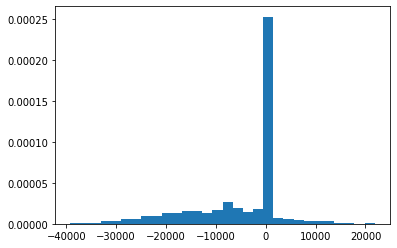

In [35]:
#mpg.plot(kind='hist')
plt.hist(lastCumCF_array, density=True, bins=30)

In [48]:
devnull = [ print(kk,'=>',summary[kk]) for kk in summary.keys()]
# https://stackoverflow.com/questions/18193205/list-comprehension-returning-values-plus-none-none-none-why

hist_filename => JPM.csv
hist_shape => (250, 6)
hist_firstdt => 2022-05-31
hist_lastdt => 2023-05-26
hist_stats => {'sigma': 0.017308744241388962, 'mu': 0.0002726544013365923, 'dretCount': 249}
paths => 1000
hist_lastclose => 136.940002
futprices => 252
exec_start_rand => 2023-09-04 21:05:17.859858
exec_start_simul => 2023-09-04 21:20:55.251093
fut_firstdt => 2023-05-29
fut_lastdt => 2024-05-14
exec_end => 2023-09-04 21:09:58.067653
contract_specs => contract.yml


In [49]:
Ploss = len(list(filter(lambda cumcf: cumcf < 0, lastCumCF_array))) / len(lastCumCF_array)
print('P[loss]=',Ploss)

P[loss]= 0.431


In [61]:
#del contract_spec.pop('offline')
devnull = contract_spec.pop('offline',None)

In [62]:
import json
print(json.dumps(contract_spec, indent=4))

{
    "contract": "CC1",
    "file": "jpm.csv",
    "market": "NYSE",
    "desc": "first cocoa. t = date of last close",
    "knock-in": "row.AdjClose > 145",
    "knock-out": "row.AdjClose <= 120",
    "dates": {
        "startdate": "2022-06-02",
        "enddate": "2024-05-22",
        "dateformat": "%Y-%m-%d",
        "filedateformat": "%Y-%m-%d"
    },
    "comments": "can use min, max, avg, abs, math.ceil(), ...",
    "missing": "forward linear",
    "buy": {
        "qty": "6",
        "at": "hist('AdjClose',T,0)",
        "when": "hist('AdjClose',T,0) > hist('AdjClose',T,-1)"
    },
    "sell": {
        "qty": "5",
        "at": "hist('AdjClose',T,0)",
        "when": "hist('AdjClose',T,0) < hist('AdjClose',T,-1)",
        "desc": "if 2% up or more, sell"
    }
}
